In [1]:
from HBV_bmi import HBV
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5  ])

## Array of parameters min/max bounds
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [3]:
config_file = f"""{{
    "forcing_file": "Forcing.txt",
    "parameters": "{','.join([str(p) for p in par_0])}",
    "initial_storage":"{','.join([str(s) for s in s_0])}",
    "timestep": 1
}}
"""

with open("HBV_config.json", "w") as f:
    f.write(config_file)

In [4]:
model = HBV()
model.initialize(config_file="HBV_config.json")

In [5]:
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))

**compare to previous implemented model**

In [6]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

In [7]:
len(Q_m)

1126

In [8]:
len(Q_m_in_ref) # issue somwhere here..? 

1127

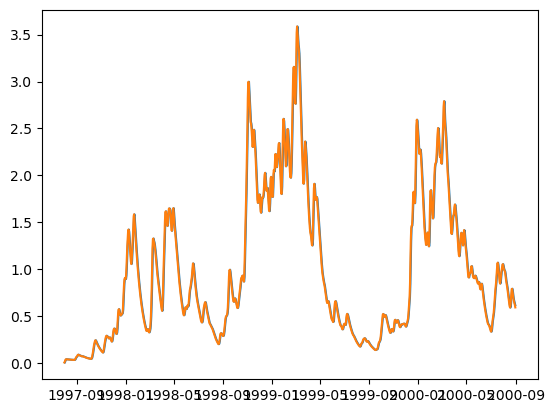

In [9]:
plt.plot(time, Q_m)
plt.plot(model.df.index, Q_m_in_ref);
# basically identical

In [10]:
n_particles = 10

In [11]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [12]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

In [13]:
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

In [19]:
model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

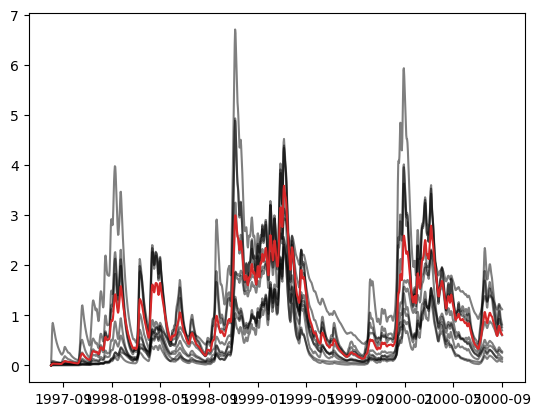

In [29]:
plt.plot(time, Q_m,zorder=100,color="C3")
for index, ensembleMember in enumerate(ensemble):
        plt.plot(time, ensembleMember.Q_m_list,color='k',alpha=0.5)